In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_addons as tfa

In [2]:
TRAIN_DIR = '../../../data/cell_type/training'
TEST_DIR = '../../../data/cell_type/testing'
VAL_DIR = '../../../data/cell_type/validation'
# INPUT_WIDTH = 27
# INPUT_HEIGHT = 27

BATCH_SIZE = 64
IMG_SIZE = (32, 32)


train_dataset = image_dataset_from_directory(TRAIN_DIR,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             interpolation='nearest',
                                             label_mode='categorical'
                                            )

validation_dataset = image_dataset_from_directory(VAL_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='nearest',
                                                  label_mode='categorical'
                                            )

test_dataset = image_dataset_from_directory(TEST_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='nearest',
                                                  label_mode='categorical'
                                            )

Found 7915 files belonging to 4 classes.
Found 990 files belonging to 4 classes.
Found 991 files belonging to 4 classes.


In [3]:
def get_class_name(class_num):
    if class_num == 0:
        return 'fibroblast'
    elif class_num == 1:
        return 'inflammatory'
    elif class_num == 2:
        return 'epithelial'
    else:
        return 'others'

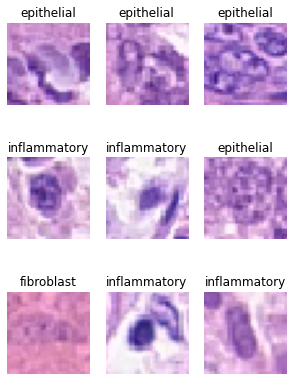

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(5, 7))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(get_class_name(tf.where(tf.equal(labels[i], 1)).numpy()[0][0]))
        plt.axis("off")

In [5]:
train_dataset.class_names

['0', '1', '2', '3']

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

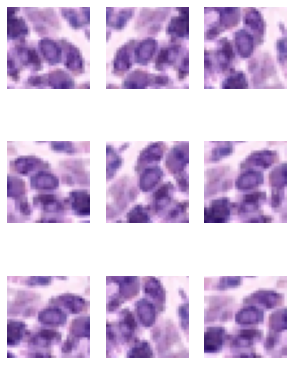

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(5, 7))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [12]:
# image_batch, label_batch = next(iter(train_dataset))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

In [13]:
# base_model.trainable = False

In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 16, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 16, 16, 32)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [16]:
prediction_layer = tf.keras.layers.Dense(4)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [17]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', f1_score ,precision_m, recall_m])

/home/trungngo/Desktop/venv/colon-cancer-classification/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [20]:
len(model.trainable_variables)

158

In [21]:
epochs = 500

loss0, accuracy0, f1_0, precision0, recall0 = model.evaluate(validation_dataset)

16/16 [==============================] - 1s 15ms/step - loss: 1.7743 - accuracy: 0.1960 - f1_score: 0.3046 - precision_m: 0.2189 - recall_m: 0.5010


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.77
initial accuracy: 0.20


In [23]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/500
124/124 [==============================] - 9s 57ms/step - loss: 1.4191 - accuracy: 0.3973 - f1_score: 0.4316 - precision_m: 0.3223 - recall_m: 0.6540 - val_loss: 1.2840 - val_accuracy: 0.4424 - val_f1_score: 0.4571 - val_precision_m: 0.3411 - val_recall_m: 0.6930
Epoch 2/500
124/124 [==============================] - 8s 62ms/step - loss: 1.2824 - accuracy: 0.4681 - f1_score: 0.4643 - precision_m: 0.3490 - recall_m: 0.6941 - val_loss: 1.1864 - val_accuracy: 0.4970 - val_f1_score: 0.4888 - val_precision_m: 0.3668 - val_recall_m: 0.7333
Epoch 3/500
124/124 [==============================] - 7s 56ms/step - loss: 1.2092 - accuracy: 0.4941 - f1_score: 0.4857 - precision_m: 0.3658 - recall_m: 0.7236 - val_loss: 1.1524 - val_accuracy: 0.5444 - val_f1_score: 0.5148 - val_precision_m: 0.3886 - val_recall_m: 0.7629
Epoch 4/500
124/124 [==============================] - 7s 57ms/step - loss: 1.1347 - accuracy: 0.5277 - f1_score: 0.5098 - precision_m: 0.3864 - recall_m: 0.7499 - val_loss

Epoch 31/500
124/124 [==============================] - 7s 57ms/step - loss: 0.7296 - accuracy: 0.7181 - f1_score: 0.6209 - precision_m: 0.4800 - recall_m: 0.8800 - val_loss: 0.7378 - val_accuracy: 0.7141 - val_f1_score: 0.6273 - val_precision_m: 0.4880 - val_recall_m: 0.8786
Epoch 32/500
124/124 [==============================] - 7s 56ms/step - loss: 0.7278 - accuracy: 0.7114 - f1_score: 0.6169 - precision_m: 0.4774 - recall_m: 0.8727 - val_loss: 0.7333 - val_accuracy: 0.7000 - val_f1_score: 0.6200 - val_precision_m: 0.4834 - val_recall_m: 0.8645
Epoch 33/500
124/124 [==============================] - 7s 56ms/step - loss: 0.7169 - accuracy: 0.7188 - f1_score: 0.6200 - precision_m: 0.4791 - recall_m: 0.8791 - val_loss: 0.7042 - val_accuracy: 0.7313 - val_f1_score: 0.6439 - val_precision_m: 0.5039 - val_recall_m: 0.8924
Epoch 34/500
124/124 [==============================] - 7s 55ms/step - loss: 0.7205 - accuracy: 0.7181 - f1_score: 0.6201 - precision_m: 0.4794 - recall_m: 0.8787 - val_

Epoch 61/500
124/124 [==============================] - 7s 56ms/step - loss: 0.6276 - accuracy: 0.7581 - f1_score: 0.6552 - precision_m: 0.5157 - recall_m: 0.8996 - val_loss: 0.6477 - val_accuracy: 0.7414 - val_f1_score: 0.6512 - val_precision_m: 0.5110 - val_recall_m: 0.8980
Epoch 62/500
124/124 [==============================] - 7s 57ms/step - loss: 0.6277 - accuracy: 0.7554 - f1_score: 0.6565 - precision_m: 0.5167 - recall_m: 0.9010 - val_loss: 0.6224 - val_accuracy: 0.7576 - val_f1_score: 0.6662 - val_precision_m: 0.5299 - val_recall_m: 0.8979
Epoch 63/500
124/124 [==============================] - 7s 60ms/step - loss: 0.6249 - accuracy: 0.7568 - f1_score: 0.6593 - precision_m: 0.5222 - recall_m: 0.8952 - val_loss: 0.6294 - val_accuracy: 0.7667 - val_f1_score: 0.6626 - val_precision_m: 0.5221 - val_recall_m: 0.9071
Epoch 64/500
124/124 [==============================] - 7s 56ms/step - loss: 0.6113 - accuracy: 0.7553 - f1_score: 0.6626 - precision_m: 0.5234 - recall_m: 0.9039 - val_

Epoch 91/500
124/124 [==============================] - 7s 55ms/step - loss: 0.5242 - accuracy: 0.7963 - f1_score: 0.6824 - precision_m: 0.5403 - recall_m: 0.9272 - val_loss: 0.5842 - val_accuracy: 0.7727 - val_f1_score: 0.6784 - val_precision_m: 0.5426 - val_recall_m: 0.9060
Epoch 92/500
124/124 [==============================] - 7s 55ms/step - loss: 0.5190 - accuracy: 0.7949 - f1_score: 0.6882 - precision_m: 0.5493 - recall_m: 0.9222 - val_loss: 0.5652 - val_accuracy: 0.7828 - val_f1_score: 0.6842 - val_precision_m: 0.5464 - val_recall_m: 0.9158
Epoch 93/500
124/124 [==============================] - 7s 55ms/step - loss: 0.5231 - accuracy: 0.7994 - f1_score: 0.6790 - precision_m: 0.5367 - recall_m: 0.9248 - val_loss: 0.5870 - val_accuracy: 0.7717 - val_f1_score: 0.6749 - val_precision_m: 0.5385 - val_recall_m: 0.9050
Epoch 94/500
124/124 [==============================] - 7s 56ms/step - loss: 0.5107 - accuracy: 0.8001 - f1_score: 0.6831 - precision_m: 0.5418 - recall_m: 0.9251 - val_

124/124 [==============================] - 7s 56ms/step - loss: 0.4301 - accuracy: 0.8323 - f1_score: 0.7004 - precision_m: 0.5586 - recall_m: 0.9396 - val_loss: 0.5533 - val_accuracy: 0.7869 - val_f1_score: 0.6884 - val_precision_m: 0.5533 - val_recall_m: 0.9115
Epoch 121/500
124/124 [==============================] - 7s 56ms/step - loss: 0.4391 - accuracy: 0.8318 - f1_score: 0.7028 - precision_m: 0.5619 - recall_m: 0.9390 - val_loss: 0.5385 - val_accuracy: 0.7859 - val_f1_score: 0.6805 - val_precision_m: 0.5453 - val_recall_m: 0.9056
Epoch 122/500
124/124 [==============================] - 7s 56ms/step - loss: 0.4314 - accuracy: 0.8371 - f1_score: 0.7030 - precision_m: 0.5599 - recall_m: 0.9454 - val_loss: 0.5456 - val_accuracy: 0.7919 - val_f1_score: 0.6904 - val_precision_m: 0.5528 - val_recall_m: 0.9195
Epoch 123/500
124/124 [==============================] - 7s 55ms/step - loss: 0.4295 - accuracy: 0.8350 - f1_score: 0.7019 - precision_m: 0.5575 - recall_m: 0.9481 - val_loss: 0.56

124/124 [==============================] - 7s 56ms/step - loss: 0.3743 - accuracy: 0.8562 - f1_score: 0.7086 - precision_m: 0.5614 - recall_m: 0.9614 - val_loss: 0.5593 - val_accuracy: 0.7859 - val_f1_score: 0.6817 - val_precision_m: 0.5400 - val_recall_m: 0.9247
Epoch 150/500
124/124 [==============================] - 7s 55ms/step - loss: 0.3623 - accuracy: 0.8593 - f1_score: 0.7130 - precision_m: 0.5680 - recall_m: 0.9587 - val_loss: 0.5434 - val_accuracy: 0.7990 - val_f1_score: 0.6819 - val_precision_m: 0.5380 - val_recall_m: 0.9314
Epoch 151/500
124/124 [==============================] - 7s 56ms/step - loss: 0.3663 - accuracy: 0.8558 - f1_score: 0.7160 - precision_m: 0.5718 - recall_m: 0.9581 - val_loss: 0.5508 - val_accuracy: 0.7980 - val_f1_score: 0.6922 - val_precision_m: 0.5529 - val_recall_m: 0.9257
Epoch 152/500
124/124 [==============================] - 7s 56ms/step - loss: 0.3618 - accuracy: 0.8577 - f1_score: 0.7134 - precision_m: 0.5680 - recall_m: 0.9597 - val_loss: 0.57

124/124 [==============================] - 7s 55ms/step - loss: 0.3037 - accuracy: 0.8860 - f1_score: 0.7320 - precision_m: 0.5871 - recall_m: 0.9729 - val_loss: 0.5929 - val_accuracy: 0.8010 - val_f1_score: 0.6914 - val_precision_m: 0.5542 - val_recall_m: 0.9206
Epoch 179/500
124/124 [==============================] - 7s 55ms/step - loss: 0.2985 - accuracy: 0.8869 - f1_score: 0.7358 - precision_m: 0.5917 - recall_m: 0.9738 - val_loss: 0.6057 - val_accuracy: 0.8061 - val_f1_score: 0.6961 - val_precision_m: 0.5593 - val_recall_m: 0.9223
Epoch 180/500
124/124 [==============================] - 7s 55ms/step - loss: 0.2978 - accuracy: 0.8853 - f1_score: 0.7369 - precision_m: 0.5940 - recall_m: 0.9713 - val_loss: 0.6176 - val_accuracy: 0.7899 - val_f1_score: 0.6990 - val_precision_m: 0.5639 - val_recall_m: 0.9195
Epoch 181/500
124/124 [==============================] - 7s 56ms/step - loss: 0.2947 - accuracy: 0.8873 - f1_score: 0.7379 - precision_m: 0.5952 - recall_m: 0.9716 - val_loss: 0.60

124/124 [==============================] - 7s 56ms/step - loss: 0.2632 - accuracy: 0.9004 - f1_score: 0.7432 - precision_m: 0.5991 - recall_m: 0.9795 - val_loss: 0.6275 - val_accuracy: 0.7970 - val_f1_score: 0.6936 - val_precision_m: 0.5577 - val_recall_m: 0.9177
Epoch 208/500
124/124 [==============================] - 7s 55ms/step - loss: 0.2492 - accuracy: 0.9057 - f1_score: 0.7472 - precision_m: 0.6044 - recall_m: 0.9795 - val_loss: 0.6125 - val_accuracy: 0.8111 - val_f1_score: 0.7034 - val_precision_m: 0.5685 - val_recall_m: 0.9236
Epoch 209/500
124/124 [==============================] - 7s 55ms/step - loss: 0.2405 - accuracy: 0.9117 - f1_score: 0.7531 - precision_m: 0.6122 - recall_m: 0.9790 - val_loss: 0.6627 - val_accuracy: 0.7970 - val_f1_score: 0.6981 - val_precision_m: 0.5655 - val_recall_m: 0.9130
Epoch 210/500
124/124 [==============================] - 7s 55ms/step - loss: 0.2535 - accuracy: 0.8994 - f1_score: 0.7509 - precision_m: 0.6088 - recall_m: 0.9805 - val_loss: 0.65

124/124 [==============================] - 7s 55ms/step - loss: 0.2164 - accuracy: 0.9181 - f1_score: 0.7653 - precision_m: 0.6262 - recall_m: 0.9849 - val_loss: 0.6914 - val_accuracy: 0.8000 - val_f1_score: 0.7062 - val_precision_m: 0.5721 - val_recall_m: 0.9233
Epoch 237/500
124/124 [==============================] - 7s 55ms/step - loss: 0.2013 - accuracy: 0.9242 - f1_score: 0.7673 - precision_m: 0.6283 - recall_m: 0.9865 - val_loss: 0.7364 - val_accuracy: 0.8071 - val_f1_score: 0.7134 - val_precision_m: 0.5862 - val_recall_m: 0.9118
Epoch 238/500
124/124 [==============================] - 7s 55ms/step - loss: 0.2078 - accuracy: 0.9233 - f1_score: 0.7725 - precision_m: 0.6360 - recall_m: 0.9847 - val_loss: 0.7158 - val_accuracy: 0.8040 - val_f1_score: 0.7108 - val_precision_m: 0.5801 - val_recall_m: 0.9187
Epoch 239/500
124/124 [==============================] - 7s 55ms/step - loss: 0.2099 - accuracy: 0.9205 - f1_score: 0.7752 - precision_m: 0.6397 - recall_m: 0.9847 - val_loss: 0.69

124/124 [==============================] - 7s 56ms/step - loss: 0.1674 - accuracy: 0.9376 - f1_score: 0.7781 - precision_m: 0.6409 - recall_m: 0.9911 - val_loss: 0.7372 - val_accuracy: 0.8051 - val_f1_score: 0.7076 - val_precision_m: 0.5772 - val_recall_m: 0.9148
Epoch 266/500
124/124 [==============================] - 7s 55ms/step - loss: 0.1604 - accuracy: 0.9414 - f1_score: 0.7801 - precision_m: 0.6439 - recall_m: 0.9905 - val_loss: 0.7212 - val_accuracy: 0.8202 - val_f1_score: 0.7191 - val_precision_m: 0.5879 - val_recall_m: 0.9266
Epoch 267/500
124/124 [==============================] - 7s 55ms/step - loss: 0.1703 - accuracy: 0.9381 - f1_score: 0.7893 - precision_m: 0.6572 - recall_m: 0.9892 - val_loss: 0.7406 - val_accuracy: 0.7970 - val_f1_score: 0.7097 - val_precision_m: 0.5828 - val_recall_m: 0.9084
Epoch 268/500
124/124 [==============================] - 7s 55ms/step - loss: 0.1739 - accuracy: 0.9351 - f1_score: 0.7823 - precision_m: 0.6472 - recall_m: 0.9902 - val_loss: 0.72

124/124 [==============================] - 7s 56ms/step - loss: 0.1572 - accuracy: 0.9416 - f1_score: 0.7934 - precision_m: 0.6627 - recall_m: 0.9898 - val_loss: 0.8048 - val_accuracy: 0.7949 - val_f1_score: 0.7196 - val_precision_m: 0.5962 - val_recall_m: 0.9088
Epoch 295/500
124/124 [==============================] - 7s 56ms/step - loss: 0.1637 - accuracy: 0.9380 - f1_score: 0.7917 - precision_m: 0.6601 - recall_m: 0.9898 - val_loss: 0.8214 - val_accuracy: 0.7919 - val_f1_score: 0.7072 - val_precision_m: 0.5807 - val_recall_m: 0.9057
Epoch 296/500
124/124 [==============================] - 7s 57ms/step - loss: 0.1381 - accuracy: 0.9502 - f1_score: 0.8038 - precision_m: 0.6758 - recall_m: 0.9927 - val_loss: 0.7413 - val_accuracy: 0.8091 - val_f1_score: 0.7268 - val_precision_m: 0.6033 - val_recall_m: 0.9149
Epoch 297/500
124/124 [==============================] - 7s 56ms/step - loss: 0.1516 - accuracy: 0.9433 - f1_score: 0.8056 - precision_m: 0.6794 - recall_m: 0.9904 - val_loss: 0.74

124/124 [==============================] - 7s 55ms/step - loss: 0.1458 - accuracy: 0.9448 - f1_score: 0.8069 - precision_m: 0.6802 - recall_m: 0.9927 - val_loss: 0.7715 - val_accuracy: 0.8071 - val_f1_score: 0.7300 - val_precision_m: 0.6090 - val_recall_m: 0.9117
Epoch 324/500
124/124 [==============================] - 7s 55ms/step - loss: 0.1306 - accuracy: 0.9520 - f1_score: 0.8180 - precision_m: 0.6964 - recall_m: 0.9923 - val_loss: 0.8165 - val_accuracy: 0.8091 - val_f1_score: 0.7441 - val_precision_m: 0.6262 - val_recall_m: 0.9178
Epoch 325/500
124/124 [==============================] - 7s 55ms/step - loss: 0.1331 - accuracy: 0.9519 - f1_score: 0.8190 - precision_m: 0.6986 - recall_m: 0.9908 - val_loss: 0.7311 - val_accuracy: 0.8030 - val_f1_score: 0.7355 - val_precision_m: 0.6135 - val_recall_m: 0.9188
Epoch 326/500
124/124 [==============================] - 7s 56ms/step - loss: 0.1233 - accuracy: 0.9546 - f1_score: 0.8226 - precision_m: 0.7020 - recall_m: 0.9943 - val_loss: 0.75

124/124 [==============================] - 7s 55ms/step - loss: 0.1112 - accuracy: 0.9594 - f1_score: 0.8285 - precision_m: 0.7100 - recall_m: 0.9953 - val_loss: 0.8269 - val_accuracy: 0.8071 - val_f1_score: 0.7401 - val_precision_m: 0.6218 - val_recall_m: 0.9146
Epoch 353/500
124/124 [==============================] - 7s 55ms/step - loss: 0.1177 - accuracy: 0.9578 - f1_score: 0.8263 - precision_m: 0.7080 - recall_m: 0.9935 - val_loss: 0.8519 - val_accuracy: 0.8010 - val_f1_score: 0.7420 - val_precision_m: 0.6298 - val_recall_m: 0.9040
Epoch 354/500
124/124 [==============================] - 7s 55ms/step - loss: 0.1114 - accuracy: 0.9621 - f1_score: 0.8298 - precision_m: 0.7128 - recall_m: 0.9940 - val_loss: 0.8018 - val_accuracy: 0.8030 - val_f1_score: 0.7332 - val_precision_m: 0.6145 - val_recall_m: 0.9095
Epoch 355/500
124/124 [==============================] - 7s 57ms/step - loss: 0.1168 - accuracy: 0.9563 - f1_score: 0.8321 - precision_m: 0.7161 - recall_m: 0.9941 - val_loss: 0.87

124/124 [==============================] - 7s 57ms/step - loss: 0.1067 - accuracy: 0.9607 - f1_score: 0.8389 - precision_m: 0.7260 - recall_m: 0.9946 - val_loss: 0.8366 - val_accuracy: 0.8081 - val_f1_score: 0.7412 - val_precision_m: 0.6261 - val_recall_m: 0.9089
Epoch 382/500
124/124 [==============================] - 7s 56ms/step - loss: 0.1118 - accuracy: 0.9599 - f1_score: 0.8315 - precision_m: 0.7153 - recall_m: 0.9941 - val_loss: 0.8507 - val_accuracy: 0.8121 - val_f1_score: 0.7413 - val_precision_m: 0.6258 - val_recall_m: 0.9095
Epoch 383/500
124/124 [==============================] - 7s 58ms/step - loss: 0.0975 - accuracy: 0.9636 - f1_score: 0.8422 - precision_m: 0.7312 - recall_m: 0.9941 - val_loss: 0.8597 - val_accuracy: 0.8081 - val_f1_score: 0.7348 - val_precision_m: 0.6190 - val_recall_m: 0.9048
Epoch 384/500
124/124 [==============================] - 7s 56ms/step - loss: 0.0993 - accuracy: 0.9656 - f1_score: 0.8426 - precision_m: 0.7318 - recall_m: 0.9946 - val_loss: 0.86

124/124 [==============================] - 7s 55ms/step - loss: 0.0958 - accuracy: 0.9658 - f1_score: 0.8459 - precision_m: 0.7372 - recall_m: 0.9933 - val_loss: 0.8421 - val_accuracy: 0.8232 - val_f1_score: 0.7526 - val_precision_m: 0.6483 - val_recall_m: 0.8979
Epoch 411/500
124/124 [==============================] - 7s 55ms/step - loss: 0.0968 - accuracy: 0.9649 - f1_score: 0.8517 - precision_m: 0.7452 - recall_m: 0.9948 - val_loss: 0.8544 - val_accuracy: 0.8081 - val_f1_score: 0.7437 - val_precision_m: 0.6320 - val_recall_m: 0.9040
Epoch 412/500
124/124 [==============================] - 7s 55ms/step - loss: 0.0919 - accuracy: 0.9655 - f1_score: 0.8581 - precision_m: 0.7552 - recall_m: 0.9946 - val_loss: 0.8429 - val_accuracy: 0.8010 - val_f1_score: 0.7499 - val_precision_m: 0.6400 - val_recall_m: 0.9061
Epoch 413/500
124/124 [==============================] - 7s 55ms/step - loss: 0.0975 - accuracy: 0.9655 - f1_score: 0.8448 - precision_m: 0.7343 - recall_m: 0.9960 - val_loss: 0.84

124/124 [==============================] - 7s 55ms/step - loss: 0.0766 - accuracy: 0.9723 - f1_score: 0.8549 - precision_m: 0.7497 - recall_m: 0.9955 - val_loss: 0.8993 - val_accuracy: 0.8081 - val_f1_score: 0.7470 - val_precision_m: 0.6395 - val_recall_m: 0.8988
Epoch 440/500
124/124 [==============================] - 7s 55ms/step - loss: 0.0865 - accuracy: 0.9708 - f1_score: 0.8525 - precision_m: 0.7462 - recall_m: 0.9955 - val_loss: 0.8728 - val_accuracy: 0.8081 - val_f1_score: 0.7453 - val_precision_m: 0.6319 - val_recall_m: 0.9096
Epoch 441/500
124/124 [==============================] - 7s 55ms/step - loss: 0.0767 - accuracy: 0.9731 - f1_score: 0.8601 - precision_m: 0.7580 - recall_m: 0.9953 - val_loss: 0.9457 - val_accuracy: 0.8121 - val_f1_score: 0.7449 - val_precision_m: 0.6373 - val_recall_m: 0.8971
Epoch 442/500
124/124 [==============================] - 7s 55ms/step - loss: 0.0862 - accuracy: 0.9699 - f1_score: 0.8549 - precision_m: 0.7504 - recall_m: 0.9947 - val_loss: 0.88

124/124 [==============================] - 7s 56ms/step - loss: 0.0782 - accuracy: 0.9727 - f1_score: 0.8589 - precision_m: 0.7558 - recall_m: 0.9957 - val_loss: 0.9183 - val_accuracy: 0.8192 - val_f1_score: 0.7529 - val_precision_m: 0.6450 - val_recall_m: 0.9050
Epoch 469/500
124/124 [==============================] - 7s 55ms/step - loss: 0.0859 - accuracy: 0.9706 - f1_score: 0.8599 - precision_m: 0.7580 - recall_m: 0.9947 - val_loss: 0.8913 - val_accuracy: 0.8081 - val_f1_score: 0.7514 - val_precision_m: 0.6449 - val_recall_m: 0.9012
Epoch 470/500
124/124 [==============================] - 7s 55ms/step - loss: 0.0890 - accuracy: 0.9684 - f1_score: 0.8590 - precision_m: 0.7574 - recall_m: 0.9938 - val_loss: 0.8442 - val_accuracy: 0.8141 - val_f1_score: 0.7449 - val_precision_m: 0.6394 - val_recall_m: 0.8929
Epoch 471/500
124/124 [==============================] - 7s 55ms/step - loss: 0.0790 - accuracy: 0.9725 - f1_score: 0.8605 - precision_m: 0.7595 - recall_m: 0.9938 - val_loss: 1.02

124/124 [==============================] - 7s 55ms/step - loss: 0.0664 - accuracy: 0.9761 - f1_score: 0.8681 - precision_m: 0.7696 - recall_m: 0.9967 - val_loss: 0.9899 - val_accuracy: 0.7960 - val_f1_score: 0.7507 - val_precision_m: 0.6456 - val_recall_m: 0.8978
Epoch 498/500
124/124 [==============================] - 7s 55ms/step - loss: 0.0727 - accuracy: 0.9742 - f1_score: 0.8695 - precision_m: 0.7720 - recall_m: 0.9963 - val_loss: 0.9440 - val_accuracy: 0.8030 - val_f1_score: 0.7521 - val_precision_m: 0.6484 - val_recall_m: 0.8961
Epoch 499/500
124/124 [==============================] - 7s 55ms/step - loss: 0.0820 - accuracy: 0.9720 - f1_score: 0.8645 - precision_m: 0.7646 - recall_m: 0.9956 - val_loss: 0.9124 - val_accuracy: 0.8182 - val_f1_score: 0.7495 - val_precision_m: 0.6463 - val_recall_m: 0.8930
Epoch 500/500
124/124 [==============================] - 7s 55ms/step - loss: 0.0671 - accuracy: 0.9768 - f1_score: 0.8746 - precision_m: 0.7807 - recall_m: 0.9953 - val_loss: 0.95

In [24]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_dataset)

16/16 [==============================] - 0s 15ms/step - loss: 0.9560 - accuracy: 0.7800 - f1_score: 0.7566 - precision_m: 0.6551 - recall_m: 0.8964
